## How does my tidal tensor change in time? 
Qui voglio moltissimo un filmato 

In [1]:
import tstrippy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
%matplotlib widget

In [2]:
def f_martos(s,gamma):
    """
    An important term in the tidal tensor
    """
    numerator = gamma -1 
    denominator = 1 + s**(gamma-1)
    return 2 - numerator/denominator

def martos_mass_profile(s,gamma):
    """
    enclosed mass of the martos halo
    """
    numerator = s**gamma
    denominator = 1 + s**(gamma-1)
    return numerator/denominator

def normalized_martos_tidal_tensor(r,gamma):
    """
    The position should be normalized to the scale radius
    r is the position vector of the satellite with respect to the system
    gamma is the mass envelope index
    """
    # Define the variables
    # assert isinstance(r,np.array), "a numpy array is expected"
    # assert isinstance(gamma, (int, float)), "a float or int is expected"
    # assert r.shape[0] == 3, "r must be a 3D vector"
    
    # get the norm of r and dr
    r_norm = np.linalg.norm(r)

    mass_enclosed = martos_mass_profile(r_norm, gamma)
    f_s = f_martos(r_norm, gamma)
    # make  the tensor
    tensor = np.zeros((3,3))
    # the diagonal elements
    tensor[0,0] = 1 -  f_s*(r[0]/r_norm)**2
    tensor[1,1] = 1 -  f_s*(r[1]/r_norm)**2
    tensor[2,2] = 1 -  f_s*(r[2]/r_norm)**2
    # the off diagonal elements
    tensor[0,1] = -f_s*(r[0]*r[1])/r_norm**2
    tensor[0,2] = -f_s*(r[0]*r[2])/r_norm**2
    tensor[1,0] = -f_s*(r[1]*r[0])/r_norm**2
    tensor[1,2] = -f_s*(r[1]*r[2])/r_norm**2
    tensor[2,0] = -f_s*(r[2]*r[0])/r_norm**2
    tensor[2,1] = -f_s*(r[2]*r[1])/r_norm**2
    # multiply by the mass enclosed
    tensor *= -(mass_enclosed/r_norm**3)
    return tensor

In [3]:
def dimesionless_miyamoto_nagai_tidal_tensor(params, xp,yp,zp):
    bp = params 
    beta = 1.0 + np.sqrt ( zp**2 + bp**2 )
    betaPrime = zp/np.sqrt(zp**2 + bp**2)
    betaPrimePrime = bp**2 / np.power(zp**2 + bp**2,3/2)
    D = np.sqrt ( xp**2 + yp**2 + beta**2 )
    T = np.zeros((3,3))
    # diagonals
    T[0,0] = 1 - 3*xp**2/D**2
    T[1,1] = 1 - 3*yp**2/D**2
    T[2,2] = betaPrime**2 + beta*betaPrimePrime - 3*(beta*betaPrime)**2 / D**2
    T[0,1] = -3*xp*yp/D**2
    T[0,2] = -3*xp*beta*betaPrime/D**2
    T[1,0] = -3*xp*yp/D**2
    T[1,2] = -3*yp*beta*betaPrime/D**2
    T[1,0] = T[0,1]
    T[2,0] = T[0,2]
    T[2,1] = T[1,2]
    T = -T/D**3
    return T

In [4]:
def miyamoto_nagai_tidal_tensor(params,x,y,z):
    """
    Miyamoto-Nagai potential
    """
    G,M,a,b = params
    # make all dimensionless for for convenience
    xp = x/a
    yp = y/a
    zp = z/a
    bp = b/a
    T = dimesionless_miyamoto_nagai_tidal_tensor(bp, xp, yp, zp)
    # scale up the tensor 
    factor = G*M/a**3
    return T*factor


In [5]:
## TIDAL DEFORMATION STUFF 
def generate_unit_sphere(npoints=30):
    # 1. Generate points on a sphere
    theta = np.linspace(0, np.pi, npoints)
    phi = np.linspace(0, 2*np.pi, npoints)
    theta, phi = np.meshgrid(theta, phi)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return x,y,z

def tidally_deform_sphere(tidal_tensor,radius,t_dyn,npoints=30):
    # make the deformed ellipsoid
    x,y,z = generate_unit_sphere(npoints)
    sphere = radius*np.array([x.flatten(), y.flatten(), z.flatten()])
    # apply the deformation 
    force = tidal_tensor @ sphere
    deformation = (1/2)*force*(t_dyn/(2*np.pi))**2
    # scale the deformation
    ellipsoid = sphere + deformation
    # reshape them
    x_deformed = ellipsoid[0].reshape(npoints,npoints)
    y_deformed = ellipsoid[1].reshape(npoints,npoints)
    z_deformed = ellipsoid[2].reshape(npoints,npoints)
    return x_deformed,y_deformed,z_deformed

In [6]:
### ORBIT STUFF 

def get_planar_velocity_vector(potential, params, pos, pseudo_e):
    """
    Sets a velocity vectors perpendicular to the radius vector and the orbital plane
    """
    # params          =   [1.0,1.0,1.0,bp] # G,M,a=1,1,1
    vel_factor      =   np.sqrt((1-pseudo_e**2))
    # get the circular velocity
    ax,ay,az,phi    =   potential(params, pos[0], pos[1], pos[2])
    F               =   np.array([ax,ay,az])
    vcir            =   np.sqrt(np.linalg.norm(pos)*np.linalg.norm(F))
    # pick a velocity vector to be perpendicular to the radius vector and the z-axis
    unitpos         =   pos/np.linalg.norm(pos)
    v_perp          =   np.cross(unitpos, [0,0,1])
    v_perp          =   v_perp/np.linalg.norm(v_perp)
    # scale up the velocity vector
    vo              =   vel_factor*vcir*v_perp
    return vo


def get_initial_conditions(potential,params,distance,inclination,psuedo_e):
    """
    get the initial conditions for the simulation, no polar orbits here! 
    """
    # set up the mass profile
    pos = distance*np.array([np.cos(np.radians(inclination)),0,np.sin(np.radians(inclination))])
    # get the velocity vector
    vo = get_planar_velocity_vector(potential, params, pos, psuedo_e)
    initialkinematics = np.array([pos[0],pos[1],pos[2],vo[0],vo[1],vo[2]])
    return initialkinematics


def get_time_info(pos,vo,dtfactor,Ndyntime,):
    """
    get the time step and number of steps
    """
    # get the time step 
    t_dyn   = 2*np.pi*np.linalg.norm(pos)/np.linalg.norm(vo)
    dt      = t_dyn*dtfactor
    integrationtime = Ndyntime*t_dyn
    # number of steps
    Nsteps = int(integrationtime/dt)
    
    return dt, Nsteps, t_dyn


In [7]:
def get_initial_conditions(potential,params,distance,inclination,psuedo_e):
    """
    get the initial conditions for the simulation, no polar orbits here! 
    """
    # set up the mass profile
    pos = distance*np.array([np.cos(np.radians(inclination)),0,np.sin(np.radians(inclination))])
    # get the velocity vector
    vo = get_planar_velocity_vector(potential, params, pos, psuedo_e)
    initialkinematics = np.array([pos[0],pos[1],pos[2],vo[0],vo[1],vo[2]])
    return initialkinematics


def get_time_info(pos,vo,dtfactor,Ndyntime,):
    """
    get the time step and number of steps
    """
    # get the time step 
    t_dyn   = 2*np.pi*np.linalg.norm(pos)/np.linalg.norm(vo)
    dt      = t_dyn*dtfactor
    integrationtime = Ndyntime*t_dyn
    # number of steps
    Nsteps = int(integrationtime/dt)
    return dt, Nsteps, t_dyn


In [8]:
def create_local_coordinate_system(pos,vel):
    """ create a coordiante system for the orbital plane at the position of the satellite """
    # get the unit vector of the position
    e1 = -pos/np.linalg.norm(pos)
    # get the unit vector of the velocity
    # remove components of the velocity vector that are in the direction of the position vector
    vel_perp = vel - np.dot(vel, e1) * e1
    e2 = vel_perp/np.linalg.norm(vel_perp)
    # get the normal vector to the orbital plane
    e3 = np.cross(e1, e2)
    # renormalize the vectors
    e1 = e1/np.linalg.norm(e1)
    e2 = e2/np.linalg.norm(e2)
    e3 = e3/np.linalg.norm(e3)
    return e1,e2,e3

def transform_surface(matrix,xs,ys,zs):
    """
    transform the surface to the local coordinate system
    """
    x,y,z = xs.flatten(),ys.flatten(),zs.flatten()
    points= np.array([x,y,z])
    # transform the points
    transformed_points = matrix @ points
    # reshape the points
    xout= transformed_points[0].reshape(xs.shape)
    yout= transformed_points[1].reshape(xs.shape)
    zout= transformed_points[2].reshape(xs.shape)
    transformed_surface = np.array([xout,yout,zout])
    return transformed_surface

In [9]:
### PLOT STUFF 
def make_figure(pagewidth=11.75, pageheight=8.5):
    fig = plt.figure(figsize=(pagewidth-2,(pageheight-2)/2,))
    gs = mpl.gridspec.GridSpec(1, 2, figure=fig,width_ratios=[1,1],height_ratios=[1])
    ax1 = fig.add_subplot(gs[0], projection='3d')
    ax3 = fig.add_subplot(gs[1], projection='3d')
    for ax in [ax1,ax3]:
        ax.xaxis.pane.set_visible(False)
        ax.yaxis.pane.set_visible(False)
        ax.zaxis.pane.set_visible(False)
        ax.set_axis_off()           # Hides everything: panes, ticks, and box
    ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='3d')
    ax2.xaxis.pane.set_visible(False)
    ax2.yaxis.pane.set_visible(False)
    ax2.zaxis.pane.set_visible(False)
    ax2.set_axis_off()           # Hides everything: panes, ticks, and box
    ax2.set_facecolor("none")        
    return fig, ax1, ax2, ax3


def do_axis1(ax1,LIMS,pos_local,plane,orbit_segment,basis_vectors,AXISPROPERTIES):
    # unpack the arguments 
    X_plane, Y_plane, Z_plane = plane
    xt,yt,zt = orbit_segment
    e1,e2,e3 = basis_vectors
    
    ax1.plot(xt,yt,zt, color='black', lw=2)
    ax1.plot(LIMS,[0,0], [0,0], color='k', lw=1)
    ax1.plot([0,0],LIMS,[0,0], color='k', lw=1)
    ax1.plot([0,0], [0,0], LIMS, color='k', lw=1)
    # add the new basis vectors to ax1
    ax1.quiver(pos_local[0], pos_local[1], pos_local[2], e1[0], e1[1], e1[2], color='black', length=5, normalize=True)
    ax1.quiver(pos_local[0], pos_local[1], pos_local[2], e2[0], e2[1], e2[2], color='blue', length=5, normalize=True)
    ax1.quiver(pos_local[0], pos_local[1], pos_local[2], e3[0], e3[1], e3[2], color='green', length=5, normalize=True)

    ax1.plot_surface(X_plane, Y_plane, Z_plane, color='lightblue', alpha=0.3, 
                    edgecolor='lightblue', linewidth=0.5)
    ax1.set(**AXISPROPERTIES)
    return ax1


def do_axis2(ax2,elipsoid,factors,eigenvectors,view_init=(30,30)):
    # unpack
    x_ell,y_ell,z_ell = elipsoid
    little_factor,axislen,little_move = factors
    
    ax2.plot_surface(x_ell, y_ell, z_ell, color='r', alpha=.9)

    ax2.plot(np.array([0,0]),np.array([0,0]),np.array([0,axislen]), color='k', lw=2)
    ax2.plot(np.array([0,0]),np.array([0,axislen]),np.array([0,0]), color='k', lw=2)
    ax2.plot(np.array([0,axislen]),np.array([0,0]),np.array([0,0]), color='k', lw=2)

    ax2.text(axislen,-little_move,little_move,'$\hat{x}$',  fontsize="small")
    ax2.text(0,axislen,little_move,'$\hat{y}$', fontsize="small")
    ax2.text(0,little_move,axislen,'$\hat{z}$', fontsize="small")

    ax2.plot([little_factor*axislen*eigenvectors[0,0],-little_factor*axislen*eigenvectors[0,0]],
            [little_factor*axislen*eigenvectors[0,1],-little_factor*axislen*eigenvectors[0,1]],
            [little_factor*axislen*eigenvectors[0,2],-axislen*little_factor*eigenvectors[0,2]], color='r',)
    ax2.set_aspect('equal')
    ax2.view_init(*view_init)
    return ax2
def do_axis3(ax3,ellipsoid_rot,eigenvectors_rot,factors,view_init=(30,30)):
    # unpack
    little_factor,axislen,little_move = factors
    ax3.plot([little_factor*axislen*eigenvectors_rot[0,0],-little_factor*axislen*eigenvectors_rot[0,0]],
            [little_factor*axislen*eigenvectors_rot[0,1],-little_factor*axislen*eigenvectors_rot[0,1]],
            [little_factor*axislen*eigenvectors_rot[0,2],-axislen*little_factor*eigenvectors_rot[0,2]], color='r',)
    ax3.plot_surface(ellipsoid_rot[0], ellipsoid_rot[1], ellipsoid_rot[2], color='r', alpha=1)

    ax3.plot(np.array([0,0]),np.array([0,0]),np.array([0,axislen]), color='green', lw=2)
    ax3.plot(np.array([0,0]),np.array([0,axislen]),np.array([0,0]), color='blue', lw=2)
    ax3.plot(np.array([0,axislen]),np.array([0,0]),np.array([0,0]), color='black', lw=2)

    ax3.text(axislen,-little_move,little_move,'-$\hat{r}$',  fontsize="small")
    ax3.text(0,axislen,little_move,'$\hat{v}$', fontsize="small")
    ax3.text(0,little_move,axislen,'-$\hat{L}$', fontsize="small")

    ax3.view_init(*view_init)
    ax3.set_aspect('equal')
    return ax3

compute an orbit

In [10]:
# ADJUSTABLE PARAMS 
distance        =   10
inclination     =   20
bp              =   1/5   # ratio of b/a, scale height to scale radius
pseudo_e        =   0.6  # pseudo eccentricity, always 0<e<1
dtfactor        =   1/1000 # time step factor, dt = t_dyn/dtfactor 
Ndyntime        =   4   # about how many orbits to do
params          =   [1.0,1.0,1.0,bp] # G,M,a=1,1,1   
potentialname   =   'miyamotonagai'
potential       =   tstrippy.potentials.miyamotonagai
initialtime     =   0.0
dx              =   1/(50) # the size of the sphere to be deformed 

In [11]:
# pack up the initial conditions 
initialkinematics = get_initial_conditions(potential,params, distance, inclination, pseudo_e)
pos,vo = initialkinematics[0:3], initialkinematics[3:6]
dt, Nsteps, t_dyn = get_time_info(pos,vo,dtfactor,Ndyntime)
# compute the orbit 
staticgalaxy            =   potentialname,params
integrationparams       =   (initialtime, dt, Nsteps)
print("integrationparams: ", integrationparams)
print("staticgalaxy: ", staticgalaxy)
print("initialkinematics: ", initialkinematics)

integrationparams:  (0.0, np.float64(0.2580191150599739), 4000)
staticgalaxy:  ('miyamotonagai', [1.0, 1.0, 1.0, 0.2])
initialkinematics:  [ 9.39692621  0.          3.42020143  0.         -0.24351627  0.        ]


In [12]:
# compute the orbit 
tstrippy.integrator.deallocate()
tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
tstrippy.integrator.setintegrationparameters(*integrationparams)
tstrippy.integrator.setinitialkinematics(*initialkinematics)
xt,yt,zt,vxt,vyt,vzt    =   tstrippy.integrator.leapfrogintime(Nsteps,1)
xt,yt,zt                =   xt[0],yt[0],zt[0]
vxt,vyt,vzt             =   vxt[0],vyt[0],vzt[0]
timesteps               = tstrippy.integrator.timestamps.copy()

In [13]:
# SOME PLOT PARAMETERS 
tail_indexes = 250
factor = 3
axislen = dx*factor
little_factor = 9/10
little_move = axislen/20

In [14]:
# GET THE STUFF THAT WILL BE CONSTANTS ACROSS ALL PLOTS 
r_max = np.max(np.sqrt(xt**2 + yt**2 + zt**2))
LIMS = (-r_max,r_max)
AXIS={
    "xlim": LIMS,
    "ylim": LIMS,
    "zlim": LIMS,
    "aspect": "equal",}

# add xy plane 
x_plane = np.linspace(LIMS[0], LIMS[1], 10)
y_plane = np.linspace(LIMS[0], LIMS[1], 10)
X_plane, Y_plane = np.meshgrid(x_plane, y_plane)
Z_plane = np.zeros_like(X_plane)  # Z=0 for XY plane
plane = X_plane, Y_plane, Z_plane

In [15]:
# pick a time index for creation the plot 
index = 500
pos_local = np.array([xt[index],yt[index],zt[index]])
vel_local = np.array([vxt[index],vyt[index],vzt[index]])
azim = (180/np.pi)*np.arctan2(pos_local[1],pos_local[0])
tidal_tensor=dimesionless_miyamoto_nagai_tidal_tensor(bp,pos_local[0],pos_local[1],pos_local[2])

In [16]:
# get orbit indexes 
upindex = index
down_index = index-tail_indexes
if down_index < 0:
    down_index = 0


In [17]:
# get the deformed sphere
x_ell,y_ell,z_ell = tidally_deform_sphere(tidal_tensor,dx,t_dyn/2)

In [18]:
# get the eigen vectots for the elipse's principal axes
eigen           =   np.linalg.eig(tidal_tensor)
eigenvectors    =   eigen.eigenvectors
eigenvalues     =   eigen.eigenvalues

In [19]:
# get the unit vectors for the local coordinates system 
e1,e2,e3= create_local_coordinate_system(pos_local,vel_local)
# make the new coordiante system 
R               = np.array([e1,e2,e3])
# put the ellipsoid in the new coordinate system
ellipsoid_rot   =transform_surface(R, x_ell,y_ell,z_ell)
# transform the eigenvectors
eigenvectors_rot=transform_surface(R, eigenvectors[0],eigenvectors[1],eigenvectors[2])


0.06

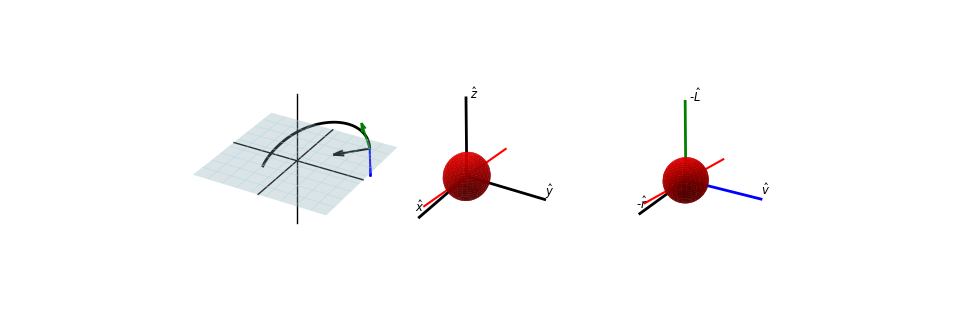

In [ ]:
fig, ax1, ax2,ax3 = make_figure()
# # add the orbit 


# def do_axis1(ax1,LIMS,pos_local,plane,orbit_segment,basis_vectors,AXISPROPERTIES):
#     # unpack the arguments 
#     X_plane, Y_plane, Z_plane = plane
#     xt,yt,zt = orbit_segment
#     e1,e2,e3 = basis_vectors
    
#     ax1.plot(xt,yt,zt, color='black', lw=2)
#     ax1.plot(LIMS,[0,0], [0,0], color='k', lw=1)
#     ax1.plot([0,0],LIMS,[0,0], color='k', lw=1)
#     ax1.plot([0,0], [0,0], LIMS, color='k', lw=1)
#     # add the new basis vectors to ax1
#     ax1.quiver(pos_local[0], pos_local[1], pos_local[2], e1[0], e1[1], e1[2], color='black', length=5, normalize=True)
#     ax1.quiver(pos_local[0], pos_local[1], pos_local[2], e2[0], e2[1], e2[2], color='blue', length=5, normalize=True)
#     ax1.quiver(pos_local[0], pos_local[1], pos_local[2], e3[0], e3[1], e3[2], color='green', length=5, normalize=True)

#     ax1.plot_surface(X_plane, Y_plane, Z_plane, color='lightblue', alpha=0.3, 
#                     edgecolor='lightblue', linewidth=0.5)
#     ax1.set(**AXISPROPERTIES)
#     return ax1



ax1=do_axis1(ax1,LIMS,pos_local,plane,(xt[down_index:upindex],yt[down_index:upindex],zt[down_index:upindex]),(e1,e2,e3),AXIS)
ax2=do_axis2(ax2,(x_ell,y_ell,z_ell),(little_factor,axislen,little_move),eigenvectors_rot,(30,30))
ax3=do_axis3(ax3,(x_ell,y_ell,z_ell),(little_factor,axislen,little_move),eigenvectors_rot,(azim,30))
axislen


In [23]:
azim

np.float64(24.658298743434738)

In [188]:
eigen=np.linalg.eig(tidal_tensor)
eigenvectors=eigen.eigenvectors
eigenvalues=eigen.eigenvalues
eigenvalues
eigenvectors[0]

array([-0.85834722, -0.41720573, -0.29862925])

In [189]:
# lets do the trace of the tidal tensor as a function of time
trace = np.zeros(Nsteps)
for i in range(Nsteps):
    x = xt[i]
    y = yt[i]
    z = zt[i]
    # compute the tidal tensor
    tidal_tensor = dimesionless_miyamoto_nagai_tidal_tensor(bp, x, y, z)
    trace[i] = np.trace(tidal_tensor)

In [190]:
# get the peaks in zt
peaks, _ = signal.find_peaks(-trace)

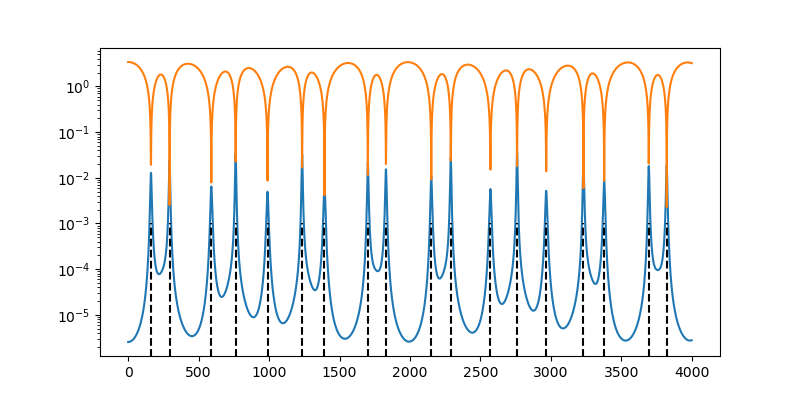

In [191]:
fig,axis=plt.subplots(1,1,figsize=(8,4))
axis.plot(np.abs(trace))
rt=np.sqrt(xt**2 + yt**2 + zt**2)
Rt = np.sqrt(xt**2 + yt**2)
# axis[0].plot(rt/10000)
# axis[0].plot(Rt/10000)
axis.plot(np.abs(zt))
axis.vlines(peaks, ymin=0, ymax=1/1000, color='k', linestyle='--')
axis.set_yscale('log')   

In [ ]:
# get the tidal tensor at this point 
# create the deformed ellipse
x,y,z = generate_unit_sphere(30)
points = np.array([x.flatten(), y.flatten(), z.flatten()])
# apply the deformation 
deformed_points = tidal_tensor @ points
# reshape the points
x_ell = deformed_points[0].reshape(x.shape)
y_ell = deformed_points[1].reshape(y.shape)
z_ell = deformed_points[2].reshape(z.shape)



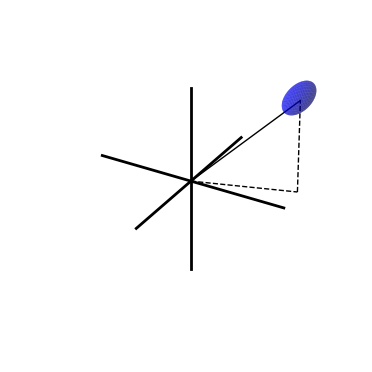

In [79]:
lims = [-4,4]

# 3. Plot
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
factor = 100
ax.plot_surface(pos[0]+factor*x_ell, pos[0]+factor*y_ell, pos[0]+factor*z_ell, color='b', alpha=0.5)
# ax.plot_surface(factor*x_ell,factor*y_ell, factor*z_ell, color='b', alpha=0.5)

# ax.quiver(0,0,0,pos[0],pos[1],pos[2], length=1, color='k', lw=2,normalize=False)
# ax.quiver(0,0,0,pos[0],pos[1],0, length=1, color='k', lw=2,normalize=False)
# ax.quiver(pos[0],pos[1],0, 0,0,pos[2], length=1, color='k', lw=2,normalize=False)
factor = 1.30
ax.plot([0, factor*pos[0]], [0, factor*pos[1]], [0, factor*pos[2]], color='k', lw=1)
ax.plot([0, factor*pos[0]], [0, factor*pos[1]], [0, 0], color='k', lw=1,linestyle='--')  
ax.plot([factor*pos[0],factor*pos[0]], [factor*pos[1],factor*pos[1]], [0, factor*pos[2]], color='k', lw=1,linestyle='--')
ax.plot(lims,[0,0], [0,0], color='k', lw=2)
ax.plot([0,0],lims,[0,0], color='k', lw=2)
ax.plot([0,0], [0,0], lims, color='k', lw=2)

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_zlim(lims)
ax.set_aspect("equal")
ax.xaxis.pane.set_visible(False)
ax.yaxis.pane.set_visible(False)
ax.zaxis.pane.set_visible(False)
ax.set_axis_off()           # Hides everything: panes, ticks, and box



$$\mathbf{v}_\text{planar} = \mathbf{v} - \left( \frac{\mathbf{v} \cdot \mathbf{r}}{|\mathbf{r}|^2} \right) \mathbf{r}$$

In [293]:
# create the local orthanomal basis 
e1 = -pos/np.linalg.norm(pos)
v_proj = np.dot(e1, pos)